# Week 11 Midterm: NLP

**Brian Roepke**  
*DATA 110*

For the given dataset, perform the following. 

1.  **Apply Preprocessing and Data Cleansing for the given analysis below:**

     - Add a new column 'Text' that combines both (title and review). This is your text corpus. (Note: if title is null (NaN) replace it with blank string first (before combining the 2 fields)
     - Add column 'text_len'  that counts the length for the derived field


2.  **Full EDA**   

     - show data summary (eg: size, columns, etc)
     - perform statistical analysis and visualization (both univariate and multivariate)


3.  **Sentiment analysis on text features**

    - apply sentiment analysis on the derived 'Text' column
    - use any lexicon-based method (eg: text-blob, vader, etc). 
    - add a column: 'polarity_score' representing the polarity score. Notes below:
        - TextBlob: polarity  >0 (considered positive), <0 (negative) ==0 (neutral)
        - Vader: compound score >= 0.05 (positive), <= -0.05 (negative) else (neutral). Note:  You will need to handle paragraphs (individual sentences) since Vader works on individual sentences. You can aggregate these and calculate the average for example.
    - add a  binary column: 'sentiment' with values 0 (negative), 1 (positive) based on the overall polarity score


4.  **Perform Part-of-speech tagging (for the entire corpus)**

    - show word counts for different parts of speech 
    - What are popular products? identify nouns that can be used to tag the product (eg: dress, jacket, bottom, etc) and show their counts
    - Identify the top adjectives and adverbs for positive vs negative reviews 


5.  **Prediction Model:**

    - create a Supervised ML model to predict whether a product will be Recommended (this is your target),  based on the text features from  (Text) along with the numeric features (text_len, polarity_score)  


6. **Text Classification Model:**

    - create a Supervised ML model to classify products by Department (this is your target) 


**For all models:**
 - apply techniques such as gridSearch, cross-validation, etc. during model building
 - use appropriate model assessment metrics to check model performance
 - test the final model on custom data


**Format your report professionally**  
 - include headings such as Overview, Preprocessing, EDA, Analysis, Conclusion, References, etc..   include text descriptions of analysis in your own words 

 - Do not just copy and paste code from Kaggle, etc.  If you use techniques from your own research, include references.

In [252]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from textblob import Word

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning & EDA

In [79]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


## Data Cleaning

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [81]:
# Change to Categorical types
df["Department Name"] = df["Department Name"].astype('category')
df["Class Name"] = df["Class Name"].astype('category')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      23486 non-null  int64   
 1   Title                    19676 non-null  object  
 2   Review Text              22641 non-null  object  
 3   Rating                   23486 non-null  int64   
 4   Recommended IND          23486 non-null  int64   
 5   Positive Feedback Count  23486 non-null  int64   
 6   Department Name          23472 non-null  category
 7   Class Name               23472 non-null  category
dtypes: category(2), int64(4), object(2)
memory usage: 1.1+ MB


In [83]:
df.shape

(23486, 8)

### Null Values

In [84]:
# check for nan/null
df.isnull().values.any()

True

In [85]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name              14
Class Name                   14
dtype: int64

In [86]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

In [87]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name               0
Class Name                    0
dtype: int64

In [88]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

In [89]:
# count of nulls
df.isnull().sum()

Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Department Name            0
Class Name                 0
dtype: int64

In [90]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [91]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

**Notes**: The title field had some null values.  For any value that was null, it has been filled with an empty string and then concatonated with the text field.

In [92]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [93]:
df.describe()

,Age,Rating,Recommended IND,Positive Feedback Count,text_len
count,22628.000000,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,0.818764,2.631784,326.215088
std,12.328176,1.115911,0.385222,5.787520,147.170892
min,18.000000,1.000000,0.000000,0.000000,12.000000
25%,34.000000,4.000000,1.000000,0.000000,201.000000
50%,41.000000,5.000000,1.000000,1.000000,319.000000
75%,52.000000,5.000000,1.000000,3.000000,478.000000
max,99.000000,5.000000,1.000000,122.000000,557.000000


### Duplicates

In [94]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before-len_after)

Before = 22628
After = 22626

Total Removed = 2


**Note**: After the prior clean up of `NULL` values, there were just `2` duplicates left.

In [95]:
# get categorical data
cat_data = df.select_dtypes(include=['category'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22626 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Department Name  22626 non-null  category
 1   Class Name       22626 non-null  category
dtypes: category(2)
memory usage: 221.9 KB


In [96]:
# show counts values of each categorical variable
for colname in cat_data.columns:
    print (colname)
    print (cat_data[colname].value_counts(), '\n')

Department Name
Tops        10048
Dresses      6145
Bottoms      3661
Intimate     1652
Jackets      1002
Trend         118
Name: Department Name, dtype: int64 

Class Name
Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1103
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               331
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: Class Name, dtype: int64 



## EDA

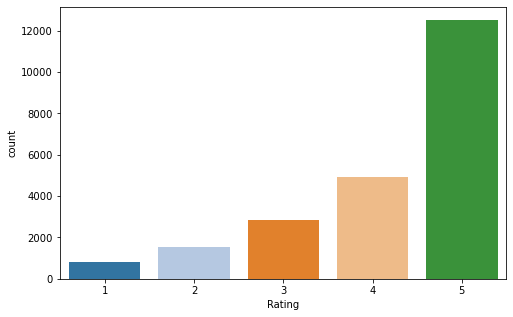

In [97]:
plt.figure(figsize=(8,5))
sns.countplot(x='Rating', data=df, palette="tab20", dodge=False);

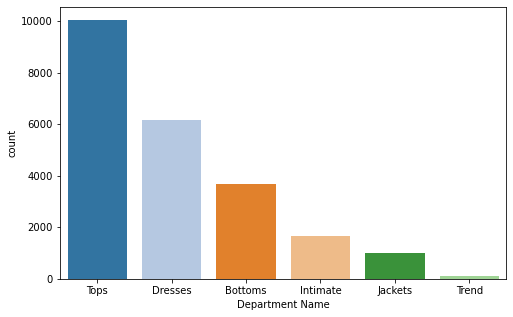

In [98]:
plt.figure(figsize=(8,5))
sns.countplot(x='Department Name', data=df, palette="tab20", 
              order = df['Department Name'].value_counts().index, dodge=False);

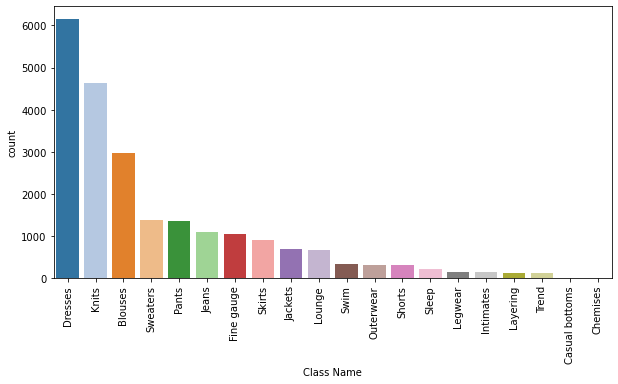

In [99]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Class Name', data=df, palette="tab20", 
                   order = df['Class Name'].value_counts().index, dodge=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

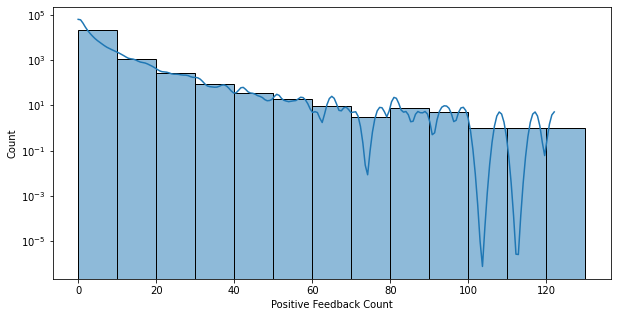

In [100]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(df, x='Positive Feedback Count', kde=True, palette="tab20c", binwidth=10);
ax.set(yscale="log");

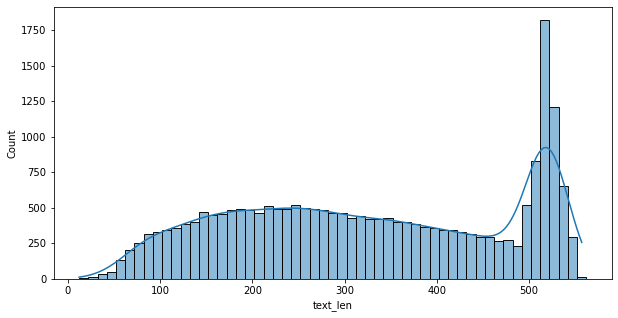

In [101]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_len', kde=True, palette="tab20c", binwidth=10);
# ax.set(yscale="log");

## Text Cleaning

In [102]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [103]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [104]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [105]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Sentiment Analysis

- apply sentiment analysis on the derived 'Text' column
- use any lexicon-based method (eg: text-blob, vader, etc). 
- add a column: 'polarity_score' representing the polarity score. Notes below:
    - TextBlob: polarity  >0 (considered positive), <0 (negative) ==0 (neutral)
    - Vader: compound score >= 0.05 (positive), <= -0.05 (negative) else (neutral). Note:  You will need to handle paragraphs (individual sentences) since Vader works on individual sentences. You can aggregate these and calculate the average for example.
- add a  binary column: 'sentiment' with values 0 (negative), 1 (positive) based on the overall polarity score

In [106]:
def get_sentiment(x):
    '''using TextBlob, get the sentiment score for a given body of text'''
    blob = TextBlob(x)
    return blob.sentiment.polarity

In [107]:
# Apply the Polarity Scoring from TextBlob
df['sentiment'] = df['Text_Processed'].apply(lambda x: get_sentiment(x))

In [108]:
# Create a few extra columns to aid in the analysis
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x >= 0 else 0)

In [109]:
df.head()

,Age,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name,Text,text_len,Text_Processed,sentiment,sentiment_label
0,33,4,1,0,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,54,absolutely wonderful silky sexy comfortable,0.633333,1
1,34,5,1,4,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,304,love dress sooo pretty happened find store im ...,0.318750,1
2,60,3,0,0,Dresses,Dresses,Some major design flaws I had such high hopes ...,524,major design flaw high hope dress really wante...,0.081439,1
3,50,5,1,0,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...",141,favorite buy love love love jumpsuit fun flirt...,0.500000,1
4,47,5,1,6,Tops,Blouses,Flattering shirt This shirt is very flattering...,209,flattering shirt shirt flattering due adjustab...,0.458333,1


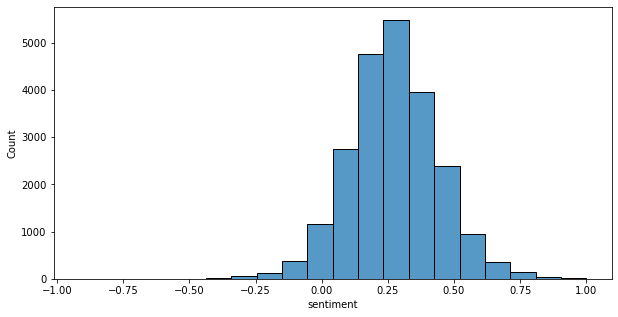

In [110]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='sentiment', palette="tab20c", bins=20);

## Part-of-speech Tagging

- show word counts for different parts of speech 
- What are popular products? identify nouns that can be used to tag the product (eg: dress, jacket, bottom, etc) and show their counts
- Identify the top adjectives and adverbs for positive vs negative reviews 

In [34]:
# Tokenize the words
df['Text_Tok'] = df['Text_Processed'].apply(word_tokenize)

In [35]:
def parse_text(x):
    '''using TextBlob, get the full parsed results (POS, etc)'''
    blob = TextBlob(x)
    p = blob.parse()
    p = re.sub(r'^\w+/', '',p)
    return p.split('/')

In [36]:
def build_pos(x):
    '''pass a DataFrame column with tokenized text and return a DF of the Words'''
    all_words = []
    for l in x:
        all_words = all_words + l
        
    df = pd.DataFrame(all_words)
    df.columns = ['Word']
    
    # Add a column for the POS
    df['Parse'] = df['Word'].apply(lambda x: parse_text(x))
    
    # Expned the extracted list of POS tags into their own columns, and concat that back to the orig DF
    # https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/
    par = pd.DataFrame(df['Parse'].to_list(), columns=['P1','P2', 'P3', 'P4'])
    df = pd.concat([df[:], par[:]], axis=1)
    df.drop(columns=['Parse'], inplace=True)

    return df

In [37]:
df_words = build_pos(df['Text_Tok'])

In [38]:
df_words.sample(10)

,Word,P1,P2,P3,P4
417022,would,MD,B-VP,O,None
408295,cloth,NN,B-NP,O,None
412142,fresh,JJ,B-ADJP,O,None
480724,jacket,NN,B-NP,O,None
114699,appears,VBZ,B-VP,O,None
346273,spring,NN,B-NP,O,None
40679,size,NN,B-NP,O,None
367935,store,NN,B-NP,O,None
404035,looking,VBG,B-VP,O,None
501383,size,NN,B-NP,O,None


**Notes:** Rather than using the much simpler approach of the POS with the TextBlog `tags` function, the `parse` function was used since it provides a more verpose labeling of the text.  

https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.tags

### Word Counts for Different Parts of Speech

In [39]:
df_top_pos = df_words.groupby('P1')['P1'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [40]:
df_top_pos

,P1,count
10,NN,269428
6,JJ,166542
20,VB,65332
16,RB,54957
21,VBD,37820
23,VBN,23676
1,CD,19369
5,IN,17498
22,VBG,16842
24,VBP,13959


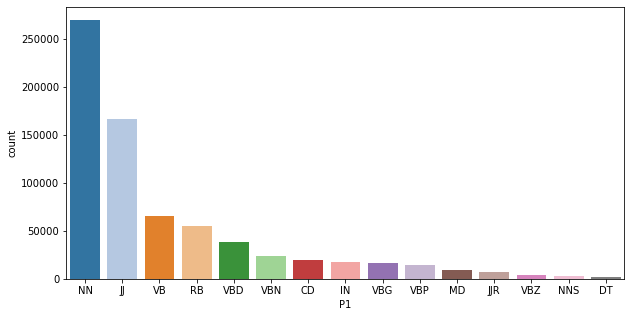

In [41]:
#import matplotlib.ticker as ticker
#ax.yaxis.set_major_formatter(ticker.EngFormatter())

plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='P1', y='count', palette="tab20");

## Identify Top Product Nouns

In [42]:
df_nn = df_words[df_words['P1'] == 'NN'].copy()

In [43]:
df_nn.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
2994,dress,12970
5449,love,10812
8332,size,9572
2151,color,7357
3371,fabric,5127
9078,sweater,3112
8139,shirt,3099
1219,bit,2947
5633,material,2922
4851,jean,2848


In [44]:
print(TextBlob('dress').parse())
print(TextBlob('love').parse())
print(TextBlob('material').parse())

dress/NN/B-NP/O
love/NN/B-NP/O
material/NN/B-NP/O


**Observations:**  When we try to use the Part of Speech (POS) tagging there isn't a distinction between Nouns. We can use the Class name to determine clothing nouns to use.

In [45]:
# Extract a list of all the unique class names
noun_types = list(df['Class Name'].unique())

# The words from the categories need to be lemmatized.
lem = WordNetLemmatizer()
for i in range(len(noun_types)):
    noun_types[i] = lem.lemmatize(noun_types[i].lower())
noun_types

['intimate',
 'dress',
 'pant',
 'blouse',
 'knit',
 'outerwear',
 'lounge',
 'sweater',
 'skirt',
 'fine gauge',
 'sleep',
 'jacket',
 'swim',
 'trend',
 'jean',
 'legwear',
 'short',
 'layering',
 'casual bottoms',
 'chemise']

In [46]:
# Extract all the text into a huge string and use Text Blobs to get a Dictionary out with counts
all_text = ' '.join(df['Text_Processed'])
all_text_blob = TextBlob(all_text)
all_text_dict = all_text_blob.word_counts

# Turn the dictionary into a Dataframe.  Filter by the word list and then sort for plotting.
df_dict = pd.DataFrame(list(all_text_dict.items()),columns = ['Word','Count']) 
df_products = df_dict[df_dict.Word.isin(noun_types)]
df_products.sort_values(by=['Count'], inplace=True, ascending=False)
df_products

,Word,Count
6,dress,12970
455,sweater,3112
362,jean,2848
460,short,2594
104,skirt,2480
154,pant,2366
512,jacket,1477
340,blouse,1188
506,knit,485
492,layering,258


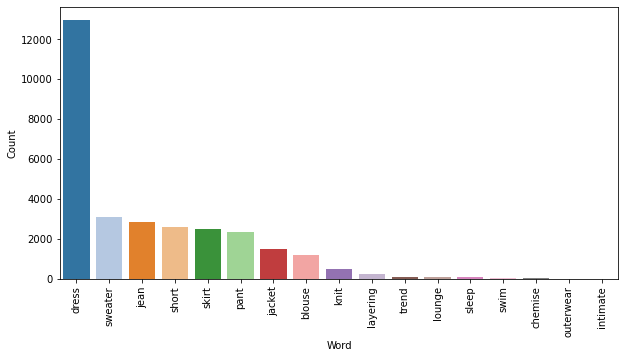

In [47]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Word', y='Count', data=df_products, palette="tab20", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Top Adjectives and Adverbs for Positive vs Negative Reviews

 - **Adjectives**: `JJ+`
 - **Adverbes**: `RB+`
 
 
**Part of Speech Codes**

<table cellpadding="2" cellspacing="2" border="0">
  <tbody><tr bgcolor="#DFDFFF" align="none"> 
    <td align="none"> 
      <div align="left">Number</div>
    </td>
    <td> 
      <div align="left">Tag</div>
    </td>
    <td> 
      <div align="left">Description</div>
    </td>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 7. </td>
    <td>JJ </td>
    <td>Adjective </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 8. </td>
    <td>JJR </td>
    <td>Adjective, comparative </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 9. </td>
    <td>JJS </td>
    <td>Adjective, superlative </td>
  </tr>

  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 20. </td>
    <td>RB </td>
    <td>Adverb </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 21. </td>
    <td>RBR </td>
    <td>Adverb, comparative </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 22. </td>
    <td>RBS </td>
    <td>Adverb, superlative </td>
  </tr>
  
</td></tr></tbody></table>
 

In [48]:
# Extract pos and neg reviews based on sentiment into their own DFs
df_pos = df[df['sentiment_label'] == 1]
df_neg = df[df['sentiment_label'] == 0]

# Drop the rest of the columns after separating
df_pos = df_pos[['Text_Tok']]
df_neg = df_neg[['Text_Tok']]

In [49]:
def get_top_mods(df_all_words):
    ''' this function will return a dataframe of the top adjetives and 
    adverbs group together and counted'''
    
    df_mods = df_all_words[(df_all_words.P1.str.startswith('JJ')) | (df_all_words.P1.str.startswith('RB'))]

    # Groupby, count, sort in order to get the counts of the words
    df_grouped = df_mods.groupby(['P1', 'Word'])['Word'].count().\
        reset_index(name='count').sort_values(['count'],ascending=False)

    # Convert to Multi-Level Index
    df_grouped.set_index(['P1', 'Word'], inplace=True)

    # Finally, just display the top 3 (if there are 3)
    return df_grouped.groupby(level=0).head(5)

In [50]:
# Build the Dataframe via the Function
df_all_words_pos = build_pos(df_pos['Text_Tok'])

# Get the top words
get_top_mods(df_all_words_pos)

count
P1  Word          
JJ  top       9293
    great     7817
    perfect   4525
    cute      4455
    small     4422
RB  really    3898
    well      3228
    back      3035
    pretty    2755
    also      2403
JJR better    1327
JJS best       642
JJR smaller    616
    shorter    595
    larger     540
JJS least      294
JJR bigger     256
JJS softest     56
    cutest      56
    biggest     47
RBR earlier     41
    sooner       6
    neater       2
    faster       2

In [51]:
# Build the Dataframe via the Function
df_all_words_neg = build_pos(df_neg['Text_Tok'])

# Get the top words
get_top_mods(df_all_words_neg)

count
P1  Word            
JJ  small        476
RB  back         227
JJ  little       211
    thin         183
RB  also         174
    really       171
    even         170
JJ  tight        147
    short        145
RB  usually      124
JJR smaller       36
JJS least         36
JJR shorter       35
    better        30
    larger        29
JJS worst         23
JJR bigger        19
JJS longest        2
RBR faster         2
JJS cutest         2
    strangest      1

# Prediction Model:

create a Supervised ML model to predict whether a product will be Recommended (this is your target),  based on the text features from  (Text) along with the numeric features (text_len, polarity_score)  

**Note on Column Transformer**:

https://stackoverflow.com/questions/55604249/featureunion-vs-columntransformer

In [ ]:
X = df[['Text', 'sentiment', 'text_len']]
y = df['sentiment_label']

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text'),
             ('Text Length', MinMaxScaler(), ['text_len']),
            ('Sentiment', MinMaxScaler(), ['sentiment'])],
            remainder='drop') 
    
    return column_trans

In [ ]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [ ]:
models = {'ComplementNB' : ComplementNB(),
          'SVC' : SVC(class_weight='balanced', random_state=42),
          'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
          'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

### Train-Test Split

In [ ]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [ ]:
print(y_train.shape)
print(X_train.shape)

In [ ]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [ ]:
parameters = [{'clf__C': np.linspace(.1, 2 ,5), 
               'clf__gamma': np.linspace(.1, 1, 5), 
               'clf__class_weight' : ['balanced']}]

clf = SVC()
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

svc_C = grid.best_params_['clf__C']
svc_gamma = grid.best_params_['clf__gamma']

### Model Validation

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [ ]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

In [ ]:
clf = SVC(C=svc_C, gamma=svc_gamma, class_weight='balanced', random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'SVC')

### Test on Custom Data

In [ ]:
def create_test_data(x):
    '''calculate the numbers needed to run on custom data including sentiment and text length,
    this is a farily simple process using the fuctions from previous transformations.'''
    
    x = process_string(x)
    sent = get_sentiment(x)
    length = len(x)
    
    d = {'Text' : x,
         'sentiment' : sent,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [ ]:
revs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
     'This skirt has really horible quality and I hate it!',
     'A super cute top with the perfect fit.',
     'The most gorgeous pair of jeans I have seen.',
     'this item is too little and tight.']

In [ ]:
print('The classifier will return 1 for Positive reviews and 0 for Negative reviews:','\n')
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', c_res)

## Text Classification Model

- Create a Supervised ML model to classify products by Department (this is your target) 

In [ ]:
# Tokenize the words
df['Department Name'] = df['Department Name'].apply(word_tokenize)

In [222]:
X = df[['Text', 'Department Name']]
y = df['Department Name']

In [223]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [224]:
print(X.shape)
print(y.shape)
print(mlb.classes_)

(22626, 2)
(22626, 6)
['Bottoms' 'Dresses' 'Intimate' 'Jackets' 'Tops' 'Trend']


In [228]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text')],
            remainder='drop') 
    
    return column_trans

In [253]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans), 
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [254]:
models = {'SVC' : OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1),
          'RF' : OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1),
          'LogReg' : OneVsRestClassifier(LogisticRegression(), n_jobs=-1),
          'BayesNB' : OneVsRestClassifier(MultinomialNB(), n_jobs=-1)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=3, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

SVC : Mean f1 Macro: 0.591 and Standard Deviation: (0.012)
RF : Mean f1 Macro: 0.444 and Standard Deviation: (0.003)
LogReg : Mean f1 Macro: 0.582 and Standard Deviation: (0.010)
BayesNB : Mean f1 Macro: 0.207 and Standard Deviation: (0.008)


### Train-Test Split

In [255]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [256]:
print(y_train.shape)
print(X_train.shape)

(15159, 6)
(15159, 2)


In [257]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=3, error_score='raise')
    grid.fit(X, y)

    return grid

In [ ]:
parameters = [{'clf__estimator__C': np.linspace(.01, 2 ,5), 
               'clf__estimator__gamma': [.1, 1, 3], 
               'clf__estimator__class_weight' : ['balanced'],
               'clf__estimator__kernel' : ['linear']}]

clf = OneVsRestClassifier(SVC())
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

svc_C = grid.best_params_['clf__estimator__C']
svc_gamma = grid.best_params_['clf__estimator__gamma']

In [ ]:
svc_C = .5
svc_gamma = .1

clf = OneVsRestClassifier(SVC(C=svc_C, gamma=svc_gamma, kernel='linear', class_weight='balanced'))
pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro')

print(metrics.classification_report(y_test, y_pred, digits=3))

In [ ]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Labels'] = pred_labels

In [ ]:
# Display a random sample of them
pd.set_option('display.max_colwidth', -1)
X_test.sample(10)